In [1]:
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.visualization.ModularVisualization import ModularServer
from mesa.datacollection import DataCollector

In [2]:
MAX_MEMORY = 10
N_AGENTS = 100
OPTIMAL_ATTENDANCE = 60

In [3]:
def calculate_attendance(model):
    return len([1 for agent in model.schedule.agents if agent.go_to_elfarol])

In [4]:
class Person(Agent):
    
    def __init__(self, uid, n_strategy, memory, model):
        super().__init__(uid, model)
        self.go_to_elfarol = 0
        self.prediction = None
        self.n_strategy = n_strategy
        self.memory = memory
        self.a_s = np.random.uniform(-1, 1, (n_strategy, memory + 1))
   
            
    def step(self):
        #print(f"I'm agent {self.unique_id} and my wealth is {self.wealth}.")
        history = self.model.attendace_history
        training_history = np.array(history[-self.memory-1:-1] + [1])
        best_strategy = np.argmin(np.abs(np.dot(self.a_s,training_history)
                                         -OPTIMAL_ATTENDANCE))
        test_history = np.array(history[-self.memory:] + [1])
        self.prediction = np.dot(self.a_s[best_strategy], test_history)
        if self.prediction <= OPTIMAL_ATTENDANCE:
            self.go_to_elfarol = 1
        else:
            self.go_to_elfarol = 0
        
        
class ElFarolModel(Model):
    
    def __init__(self, N):
        super().__init__()
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.attendace_history = [
            np.random.randint(OPTIMAL_ATTENDANCE-10, OPTIMAL_ATTENDANCE+10)
            for _ in range(MAX_MEMORY+1)]
        
        for i in range(0, self.num_agents):
            a = Person(i, 80, np.random.randint(1,MAX_MEMORY), self)
            self.schedule.add(a)
           
        self.datacollector = DataCollector(
                             model_reporters={"Attendace": calculate_attendance},
                             agent_reporters={"Go_to_elfarol": "go_to_elfarol",
                                              "Prediction": "prediction"}
                             )
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        real_attendance = calculate_attendance(self)
        self.attendace_history.append(real_attendance)
                         

In [5]:
model = ElFarolModel(N_AGENTS)
for _ in range(500):
    model.step()

/Users/simoneconradi/anaconda3/lib/python3.11/site-packages/mesa/time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)


In [6]:
model.datacollector.get_model_vars_dataframe()

,Attendace
0,0
1,49
2,61
3,51
4,59
...,...
495,65
496,49
497,65
498,46


<Axes: >

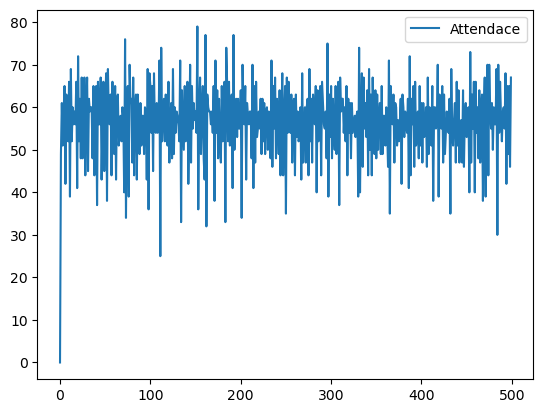

In [7]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [8]:
gini.mean()

Attendace    56.286
dtype: float64

In [9]:
agent_data = model.datacollector.get_agent_vars_dataframe()
agent_data

Go_to_elfarol  Prediction
Step AgentID                           
0    0                    0         NaN
     1                    0         NaN
     2                    0         NaN
     3                    0         NaN
     4                    0         NaN
...                     ...         ...
499  27                   0   70.667487
     15                   0   84.340157
     10                   1   54.351417
     80                   1   41.436122
     19                   1   35.041750

[50000 rows x 2 columns]

In [10]:
agent_data.groupby(["AgentID"]).sum("Go_to_elfarol")["Go_to_elfarol"].values

array([334, 302, 252, 318, 209, 252, 265, 314, 362, 348, 281, 331, 361,
       271, 316, 229, 176, 286, 260, 258, 373, 127, 359, 276, 235, 257,
       328, 263, 280, 201, 276, 257, 303, 328, 284, 297, 225, 241, 287,
       245, 147, 391, 294, 289, 334, 311, 273, 298, 266, 381, 250, 268,
       281, 234, 224, 169, 265, 352, 340, 224, 216, 227, 174, 202, 298,
       282, 300, 213, 304, 274, 204, 326, 179, 365, 271, 264, 245, 315,
       294, 264, 447, 327, 335, 269, 350, 287, 307, 348, 253, 391, 306,
       265, 280, 329, 408, 257, 324, 308, 147, 230])